<a href="https://colab.research.google.com/github/rajiv-ranjan/cds-mini-projects/blob/saif/M5_NB_MiniProject_01_MLR_MPI_OpenMP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Certification Program in Computational Data Science
## A program by IISc and TalentSprint
### Mini-Project: Implementation of Multiple Linear Regression using MPI and OpenMP

## Learning Objectives

At the end of the mini-project, you will be able to :

* understand the collective communication operations like scatter, gather, broadcast
* understand the blocking and non-blocking communication
* implement multiple linear regression and run it using MPI
* implement the multiple linear regression based predictions using OpenMP

### Dataset

The dataset chosen for this mini-project is [Combined Cycle Power Plant](https://archive.ics.uci.edu/ml/datasets/combined+cycle+power+plant). The dataset is made up of 9568 records and 5 columns. Each record contains the values for Ambient Temperature, Exhaust Vaccum, Ambient Pressure, Relative Humidity and Energy Output.

Predicting full load electrical power output of a base load power plant is important in order to maximize the profit from the available megawatt hours.  The base load operation of a power plant is influenced by four main parameters, which are used as input variables in the dataset, such as ambient temperature, atmospheric pressure, relative humidity, and exhaust steam pressure. These parameters affect electrical power output, which is considered as the target variable.

**Note:** The data was collected over a six year period (2006-11).

## Information

#### MPI in a Nutshell

MPI stands for "Message Passing Interface". It is a library of functions (in C / Python) or subroutines (in Fortran) that you insert into source code to perform data communication between processes. MPI was developed over two years of discussions led by the MPI Forum, a group of roughly sixty people representing some forty organizations.

To know more about MPI click [here](https://hpc-tutorials.llnl.gov/mpi/)


#### Multiple Linear Regression

Multiple regression is an extension of simple linear regression. It is used when we want to predict the value of a variable based on the value of two or more other variables. The variable we want to predict is called the dependent variable (or sometimes, the outcome, target or criterion variable). The variables we are using to predict the value of the dependent variable are called the independent variables (or sometimes, the predictor, explanatory or regressor variables).

**Note:** We will be using the mpi4py Python package for MPI based code implementation

## Grading = 20 Points

**Run the below code to install mpi4py package**

In [ ]:
!pip install mpi4py

#### Importing Necessary Packages

In [ ]:
# Importing pandas
import pandas as pd
# Importing Numpy
import numpy as np
# Importing MPI from mpi4py package
from mpi4py import MPI
# Importing sqrt function from the Math
from math import sqrt
# Importing Decimal, ROUND_HALF_UP functions from the decimal package
from decimal import Decimal, ROUND_HALF_UP
import time
import matplotlib.pyplot as plt
import seaborn as sns

#### Downloading the data

In [ ]:
#@title Download the data
!wget -qq https://cdn.iisc.talentsprint.com/CDS/Datasets/PowerPlantData.csv

### Overview

* Load the data and perform data pre-processing
* Identify the features, target and split the data into train and test
* Implement multiple Linear Regression by estimating the coefficients on the given data
* Use MPI package to distribute the data and implement `communicator`
* Define functions for each objective and make a script (.py) file to execute using MPI command
* Use OpenMP component to predict the data and calculate the error on the predicted data
* Implement the Linear Regression from `sklearn` and compare the results

#### Exercise 1: Load data (1 point)

Write a function that takes the filename as input and loads the data in a pandas dataframe with the column names as Ambient Temperature, Exhaust Vaccum, Ambient Pressure, Relative Humidity and Energy Output respectively.

**Hint:** read_csv()


In [ ]:
FILENAME = "/content/PowerPlantData.csv" # File path

# YOUR CODE HERE to Define a function to load the data
df = pd.read_csv(FILENAME)
df.head()

,AT,V,AP,RH,PE
0,8.34,40.77,1010.84,90.01,480.48
1,23.64,58.49,1011.40,74.20,445.75
2,29.74,56.90,1007.15,41.91,438.76
3,19.07,49.69,1007.22,76.79,453.09
4,11.80,40.66,1017.13,97.20,464.43


In [ ]:
def load_data(filename):
    df1 = pd.read_csv(filename)
    df1.columns = [
        "Ambient Temperature",
        "Exhaust Vaccum",
        "Ambient Pressure",
        "Relative Humidity",
        "Energy Output"
    ]
    return df1
df = load_data(FILENAME)
df.head()

,Ambient Temperature,Exhaust Vaccum,Ambient Pressure,Relative Humidity,Energy Output
0,8.34,40.77,1010.84,90.01,480.48
1,23.64,58.49,1011.40,74.20,445.75
2,29.74,56.90,1007.15,41.91,438.76
3,19.07,49.69,1007.22,76.79,453.09
4,11.80,40.66,1017.13,97.20,464.43


#### Exercise 2: Explore data (1 point)

Write a function that takes the data loaded using the above defined function as input and explore it.

**Hint:** You can define and check for following things in the dataset inside a function

- checking for the number of rows and columns
- summary of the dataset
- check for the null values
- check for the duplicate values

In [ ]:
# YOUR CODE HERE
def explore_data(df):
    print("1. Shape of the dataset (rows, columns):")
    print(df.shape)
    print("\n2. Summary of the dataset:")
    print(df.describe(include='all'))
    print("\n3. Checking for null values:")
    print(df.isnull().sum())
    print("\n4. Checking for duplicate rows:")
    duplicate_count = df.duplicated().sum()
    print(f"Number of duplicate rows: {duplicate_count}")
    print("\n5. Checking data type:")
    print(df.dtypes)

In [ ]:
explore_data(df)

1. Shape of the dataset (rows, columns):
(9568, 5)

2. Summary of the dataset:
       Ambient Temperature  Exhaust Vaccum  Ambient Pressure  \
count          9568.000000     9568.000000       9568.000000   
mean             19.651231       54.305804       1013.259078   
std               7.452473       12.707893          5.938784   
min               1.810000       25.360000        992.890000   
25%              13.510000       41.740000       1009.100000   
50%              20.345000       52.080000       1012.940000   
75%              25.720000       66.540000       1017.260000   
max              37.110000       81.560000       1033.300000   

       Relative Humidity  Energy Output  
count        9568.000000    9568.000000  
mean           73.308978     454.365009  
std            14.600269      17.066995  
min            25.560000     420.260000  
25%            63.327500     439.750000  
50%            74.975000     451.550000  
75%            84.830000     468.430000  
max     

#### Exercise 3: Handle missing data (1 point)

After exploring the dataset if there are any null values present in the dataset then define a function that takes data loaded using the above defined function as input and handle the null values accordingly.

**Hint:**

- Drop the records containing the null values - dropna()
- Replace the null values with the mean/median/mode - fillna()

In [ ]:
# Function to handle missing data
# YOUR CODE HERE
df = df.drop_duplicates().reset_index(drop=True)
df.shape

(9527, 5)

#### Exercise 4: Scale the data (1 point)

Write a function that takes the data after handling the missing data as input and returns the standardized data.

**Hint:**

- standardization of the data  can be performed using the below formula

$ (x - mean(x)) / std(x) $

In [ ]:
# Defining a function to standardize the data

# YOUR CODE HERE
def standardize_data(df):
    df_2 = (df - df.mean()) / df.std()
    return df_2

df3 = standardize_data(df)
df3.head()

,Ambient Temperature,Exhaust Vaccum,Ambient Pressure,Relative Humidity,Energy Output
0,-1.520368,-1.065985,-0.403514,1.141539,1.534360
1,0.534869,0.330796,-0.309246,0.059219,-0.503895
2,1.354277,0.205464,-1.024671,-2.151287,-0.914129
3,-0.079016,-0.362865,-1.012887,0.236525,-0.073121
4,-1.055589,-1.074656,0.655315,1.633752,0.592408


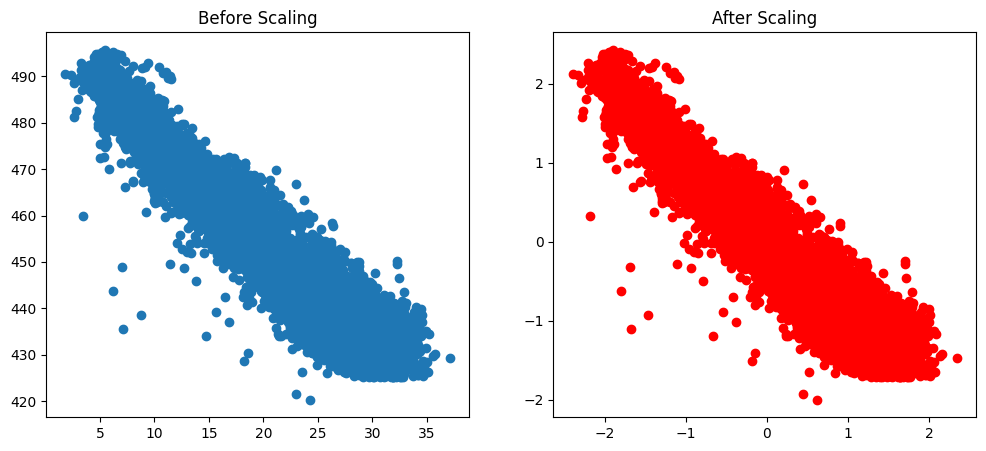

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))

ax1.scatter(df['Ambient Temperature'], df['Energy Output'])
ax1.set_title("Before Scaling")
ax2.scatter(df3['Ambient Temperature'], df3['Energy Output'],color='red')
ax2.set_title("After Scaling")
plt.show()

#### Exercise 5: Feature selection (1 point)

Write a function that takes scaled data as input and returns the features and target variable values

**Hint:**

- Features: AmbientTemperature, ExhaustVaccum, AmbientPressure, RelativeHumidity
- Target Variable: EnergyOutput

In [ ]:
# Define a function

# YOUR CODE HERE
def split_features_target(df):

    feature_columns = [
        "Ambient Temperature",
        "Exhaust Vaccum",
        "Ambient Pressure",
        "Relative Humidity"
    ]
    target_column = "Energy Output"

    X = df[feature_columns]
    y = df[target_column]

    return X, y

In [ ]:
X, y = split_features_target(df3)

print("Features Column:\n",X.head())
print("\n Target Column:\n",y.head())

Features Column:
    Ambient Temperature  Exhaust Vaccum  Ambient Pressure  Relative Humidity
0            -1.520368       -1.065985         -0.403514           1.141539
1             0.534869        0.330796         -0.309246           0.059219
2             1.354277        0.205464         -1.024671          -2.151287
3            -0.079016       -0.362865         -1.012887           0.236525
4            -1.055589       -1.074656          0.655315           1.633752

 Target Column:
 0    1.534360
1   -0.503895
2   -0.914129
3   -0.073121
4    0.592408
Name: Energy Output, dtype: float64


#### Exercise 6: Correlation (1 point)

Calculate correlation between the variables

In [ ]:
# YOUR CODE HERE
correlation_matrix = df3.corr(numeric_only=True)
print("Correlation matrix:\n")
print(correlation_matrix)

Correlation matrix:

                     Ambient Temperature  Exhaust Vaccum  Ambient Pressure  \
Ambient Temperature             1.000000        0.843689         -0.508222   
Exhaust Vaccum                  0.843689        1.000000         -0.415718   
Ambient Pressure               -0.508222       -0.415718          1.000000   
Relative Humidity              -0.543947       -0.312214          0.101631   
Energy Output                  -0.947908       -0.869900          0.518687   

                     Relative Humidity  Energy Output  
Ambient Temperature          -0.543947      -0.947908  
Exhaust Vaccum               -0.312214      -0.869900  
Ambient Pressure              0.101631       0.518687  
Relative Humidity             1.000000       0.391175  
Energy Output                 0.391175       1.000000  


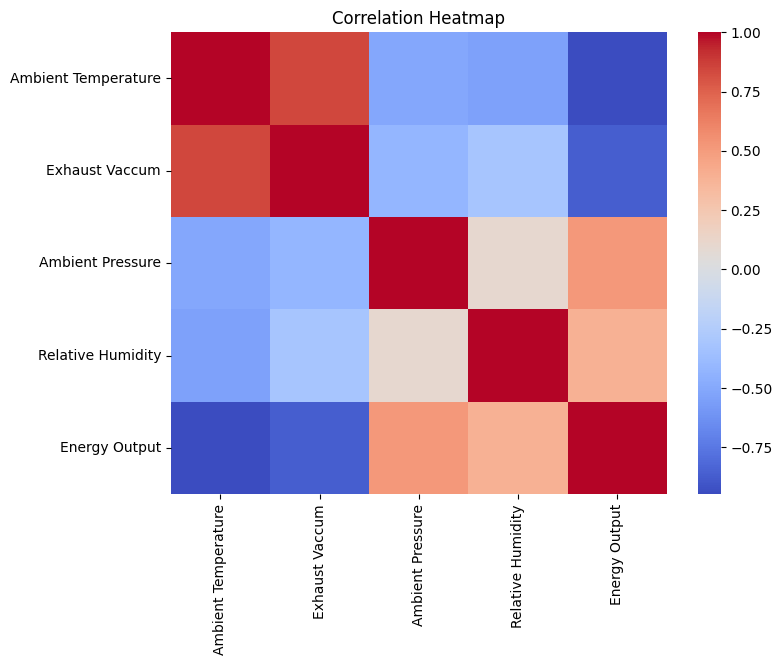

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

#### Exercise 7: Estimate the coefficients (2 points)

Write a function that takes features and target as input and returns the estimated coefficient values

**Hint:**

- Calculate the estimated coefficients using the below formula

$ β = (X^T X)^{-1} X^T y $

- transpose(), np.linalg.inv()

In [ ]:
# Calculating the coeffients

# YOUR CODE HERE
def estimate_coefficients(X, y):

   beta = np.linalg.inv(X.T @ X) @ X.T @ y
   return beta

#### Exercise 8: Fit the data to estimate the coefficients (2 points)

Write a function named fit which takes features and targets as input and returns the intercept and coefficient values.

**Hint:**

- create a dummy column in the features dataframe which is made up of all ones
- convert the features dataframe into numpy array
- call the estimated coefficients function which is defined above
- np.ones(), np.concatenate()

In [ ]:
# defining a fit function
def fit(x, y):
    # YOUR CODE HERE
    X_np = X.to_numpy()
    y_np = y.to_numpy().reshape(-1, 1)

    ones = np.ones((X_np.shape[0], 1))
    X_b = np.hstack((ones, X_np))

    beta = estimate_coefficients(X_b, y_np)

    intercept = beta[0][0]
    coefficients = beta[1:].flatten()

    return intercept, coefficients

X, y = split_features_target(df3)

intercept, coefficients = fit(X, y)
print("Intercept:", intercept)
print("Coefficients:", coefficients)

Intercept: 1.021691140978137e-15
Coefficients: [-0.86225353 -0.17575667  0.02111203 -0.13486446]


#### Exercise 9: Predict the data on estimated coefficients (1 point)

Write a function named predict which takes features, intercept and coefficient values as input and returns the predicted values.

**Hint:**

- Fit the intercept, coefficients values in the below equation

  $y = b_0 + b_1*x + ... + b_i*x_i$

In [ ]:
 # fucntion to predict the values
def predict(x, intercept, coefficients):
    '''
    y = b_0 + b_1*x + ... + b_i*x_i
    '''
    #YOUR CODE HERE
    if isinstance(x, pd.DataFrame):
        X = x.to_numpy()
    predictions = intercept + np.dot(x, coefficients) #y = b_0 + b_1*x + ... + b_i*x_i

    return predictions

predictions = predict(X, intercept, coefficients)

print("Predicted values:",predictions[:])
print("\n Shape:",predictions.shape[0])

Predicted values: [ 1.33582488 -0.53384742 -0.93534243 ...  0.53088277 -0.02245769
 -0.40990677]

 Shape: 9527


#### Exercise 10: Root mean squared error (1 point)

Write a function to calculate the RMSE error.

**Hint:**

- [How to calculate the RSME error](https://towardsdatascience.com/what-does-rmse-really-mean-806b65f2e48e)

In [ ]:
# Define a function to calculate the error

# YOUR CODE HERE
def calculate_rmse(y, y_pred):

    y_true = np.array(y)
    y_pred = np.array(y_pred)

    mse = np.mean((y_true - y_pred) ** 2)
    rmse = np.sqrt(mse)
    return rmse

rmse = calculate_rmse(y, predictions)

print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

Root Mean Squared Error (RMSE): 0.27


#### Exercise 11: Split the data into train and test (1 point)

Write a function named train_test_split which takes features and targets as input and returns the train and test sets respectively.

**Hint:**

- Shuffle the data
- Consider 70 % of data as a train set and the rest of the data as a test set

In [94]:
# YOUR CODE HERE
def train_test_split(X, y, train_size=0.7, random_seed=None):

    X = np.array(X)
    y = np.array(y)

    if random_seed is not None:
        np.random.seed(random_seed)

    # Shuffle the data
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)

    X_shuffled = X[indices]
    y_shuffled = y[indices]

    split_index = int(train_size * X.shape[0])

    X_train = X_shuffled[:split_index]
    X_test = X_shuffled[split_index:]
    y_train = y_shuffled[:split_index]
    y_test = y_shuffled[split_index:]

    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_seed=42)

print("Train set size:", X_train.shape[0])
print("Test set size:", X_test.shape[0])

Train set size: 6668
Test set size: 2859


#### Exercise 12: Implement predict using OpenMP (1 point)

Get the predictions for test data and calculate the test error(RMSE) by implementing the OpenMP (pymp)

**Hints:**

* Using the pymp.Parallel implement the predict function (use from above)

* Call the predict function by passing test data as an argument

* calculate the error (RMSE) by comparing the Actual test data and predicted test data

In [ ]:
!pip install pymp-pypi

In [ ]:
def fit2(x, y):
    # YOUR CODE HERE
    X_ = x
    y_ = y.reshape(-1, 1)

    ones = np.ones((X_.shape[0], 1))
    X_b = np.concatenate((ones, X_), axis=1)

    beta = estimate_coefficients(X_b, y_)

    intercept = beta[0][0]
    coefficients = beta[1:].flatten()

    return intercept, coefficients

In [ ]:
import pymp
# YOUR CODE HERE

#Serial prediction
def serial_predict(X, intercept, coefficients):
    return intercept + np.dot(X, coefficients)

#parallel prediction
def parallel_predict(X, intercept, coefficients, num_threads):

    X = np.array(X)
    n_samples = X.shape[0]
    y_pred = pymp.shared.array(n_samples, dtype='float')

    with pymp.Parallel(num_threads) as p:
        for i in p.range(n_samples):
            y_pred[i] = intercept + np.dot(X[i], coefficients)

    return np.array(y_pred)

#RSME
def calculate_rmse(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    mse = np.mean((y_true - y_pred) ** 2)
    return np.sqrt(mse)

# Fit model
intercept, coefficients = fit2(X_train, y_train)

In [ ]:
# Serial prediction timing
start_serial = time.time()
y_pred_serial = serial_predict(X_test, intercept, coefficients)
end_serial = time.time()

# Predict on test data using pymp
start_parallel = time.time()
y_pred_test = parallel_predict(X_test, intercept, coefficients, num_threads=4)
end_parallel = time.time()

# RMSE
rmse_serial = calculate_rmse(y_test, y_pred_serial)
rmse_parallel = calculate_rmse(y_test, y_pred_test)

# Print
print(f"RMSE (Serial): {rmse_serial:.4f}")
print(f"RMSE (Parallel): {rmse_parallel:.4f}")

print(f"Serial Prediction Time: {end_serial - start_serial:.6f} seconds")
print(f"Parallel Prediction Time: {end_parallel - start_parallel:.6f} seconds")

RMSE (Serial): 0.2692
RMSE (Parallel): 0.2692
Serial Prediction Time: 0.000219 seconds
Parallel Prediction Time: 0.358592 seconds


#### Exercise 13: Create a communicator (1 point)

Create a comunicator and define the rank and size

In [109]:
# YOUR CODE HERE
def init_mpi():

    comm = MPI.COMM_WORLD        # Default communicator
    rank = comm.Get_rank()       # Rank
    size = comm.Get_size()       # Size

    return comm, rank, size

comm, rank, size = init_mpi()
rank = 0
size = 4
print(f"Process {rank} of {size} is running.")

Process 0 of 4 is running.


#### Exercise 14: Divide the data into slices (1 point)

Write a function named dividing_data which takes train features set, train target set, and size of workers as inputs and returns the sliced data for each worker.

![img](https://cdn.iisc.talentsprint.com/CDS/Images/MiniProject_MPI_DataSlice.JPG)

For Example, if there are 4 processes, slice the data into 4 equal parts with 25% ratio

**Hint:**

- Divide the Data equally among the workers
  - Create an empty list
  - Iterate over the size of workers
  - Append each slice of data to the list

In [111]:
def dividing_data(x_train, y_train, size):
    # Size of the slice
    slice_for_each_worker = int(Decimal(x_train.shape[0]/size).quantize(Decimal('1.'), rounding = ROUND_HALF_UP))
    print('Slice of data for each worker: {}'.format(slice_for_each_worker))
    # YOUR CODE HERE
    divided_data = []
    total_samples = x_train.shape[0]

    for i in range(size):
        start_idx = i * slice_for_each_worker
        # the last worker gets all remaining data
        end_idx = (i + 1) * slice_for_each_worker if i != size - 1 else total_samples

        x_slice = x_train[start_idx:end_idx]
        y_slice = y_train[start_idx:end_idx]

        divided_data.append((x_slice, y_slice))

    return divided_data

divided = dividing_data(X, y, size)

for i, (x_part, y_part) in enumerate(divided):
    print(f"Worker {i}: {x_part.shape[0]} samples")

Slice of data for each worker: 2382
Worker 0: 2382 samples
Worker 1: 2382 samples
Worker 2: 2382 samples
Worker 3: 2381 samples


#### Exercise 15: Prepare the data in root worker to assign data for all the workers (1 point)

- When it is the root worker, perform the below operation:
    - Store the features and target values in separate variables
    - Split the data into train and test sets using the train_test_split function defined above
    - Divide the data among the workers using the dividing_data function above

In [112]:
# YOUR CODE HERE
def prepare_data_for_workers(X, y, num_workers):

    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_seed=42)
    divided_data = dividing_data(X_train, y_train, num_workers)

    return divided_data, X_test, y_test
if rank == 0:
        divided_data, X_test, y_test = prepare_data_for_workers(X, y, size)
        print(f"Root process prepared data for {size} workers.")
        print(divided_data)

Slice of data for each worker: 1667
Root process prepared data for 4 workers.
[(array([[ 1.82711572,  1.12062375, -0.12576059, -1.41399503],
       [-1.50156217, -1.2449185 ,  0.04425802, -0.46722197],
       [-1.46529328, -1.4183338 ,  0.39944542, -1.08197411],
       ...,
       [-1.19797815, -0.83739256, -0.25032868,  0.46312118],
       [ 0.33606146,  0.35680821, -0.61056614,  0.94643411],
       [ 0.55367479, -0.39360706, -1.67276163,  0.22078014]]), array([-1.46462772,  1.81665264,  1.52966533, ...,  1.3489044 ,
       -0.56199685, -0.85133171])), (array([[ 1.17561904,  0.99450354, -0.84455215, -1.05459094],
       [ 0.6020333 ,  0.70285054, -0.161111  ,  1.07787332],
       [ 0.64233207,  1.51396117, -0.29409585,  0.96217943],
       ...,
       [ 0.56173454,  0.4395746 ,  0.98861883, -0.94095079],
       [ 0.36830047,  0.30163062,  0.33716137,  0.32141328],
       [-1.79977302, -1.02341988, -1.88486406,  0.97244812]]), array([-0.81083657, -0.79792508, -0.9745778 , ..., -0.72749

#### Exercise 16: Scatter and gather the data (1 point)

Perform the below operations:

- Send slices of the training set(the features data X and the expected target data Y) to every worker including the root worker
    - **Hint:** scatter()
    - use `barrier()` to block workers until all workers in the group reach a Barrier, to scatter from root worker.
- Every worker should get the predicted target Y(yhat) for each slice
- Get the new coefficient of each instance in a slice
    - **Hint:** fit function defined above
- Gather the new coefficient from each worker
    - **Hint:** gather()
    - Take the mean of the gathered coefficients
- Calculate the root mean square error for the test set

To know more about `scatter`, `gather` and `barrier` click [here](https://nyu-cds.github.io/python-mpi/05-collectives/)

In [113]:
# YOUR CODE HERE
# Sync all workers
comm.Barrier()
start_time = time.time()    # Start timing

root = 0
data_slice = comm.scatter(divided_data, root)
X_slice, y_slice = data_slice

intercept, coefficients = fit2(X_slice, y_slice)

local_params = np.insert(coefficients, 0, intercept)  # [b0, b1, b2, ...]

end_time = time.time()  # End timing
elapsed_time = end_time - start_time    # timing

print(f"Worker {rank} completed training in {elapsed_time:.4f} seconds.")

# Gather coefficients from all workers at root
all_params = comm.gather(local_params, root)
all_times = comm.gather(elapsed_time, root)

if rank == 0:
    all_params = np.array(all_params)
    avg_params = np.mean(all_params, axis=0)

    final_intercept = avg_params[0]
    final_coefficients = avg_params[1:]

    y_pred_test = predict(X_test, final_intercept, final_coefficients)

    # Evaluate RMSE
    rmse = calculate_rmse(y_test, y_pred_test)
    print(f"\n Final RMSE on Test Set (using averaged coefficients): {rmse:.4f}")

ValueError: expecting 1 items, got 4

In [106]:
# ---- VISUAL COMPARISON ----
# print("Coefficients from each worker:")
# for i, params in enumerate(all_params):
#     print(f"Worker {i}: Intercept = {params[0]:.4f}, Coeffs = {params[1:]}")

# print("\n Execution Time per Worker:")
# for i, t in enumerate(all_times):
#     print(f"Worker {i}: {t:.4f} seconds")

# # Plot coefficients per worker
# plt.figure(figsize=(10, 5))
# for i, params in enumerate(all_params):
#     plt.plot(params[1:], label=f"Worker {i}")
# plt.plot(avg_params[1:], label="Average", linewidth=3, linestyle='--', color='black')
# plt.title("Feature Coefficients Per Worker vs. Averaged Model")
# plt.xlabel("Feature Index")
# plt.ylabel("Coefficient Value")
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()

#### Exercise 17: Make a script and execute everything in one place (1 point)

Write a script(.py) file which contains the code of all the above exercises in it so that you can run the code on multiple processes using MPI.

**Hint:**

- magic commands
- put MPI related code under main function
- !mpirun --allow-run-as-root -np 4 python filename.py

In [107]:
# YOUR CODE HERE for scipt(.py)
%%writefile parallel_linear_regression_mpi.py
from mpi4py import MPI
import numpy as np
import pandas as pd
from decimal import Decimal, ROUND_HALF_UP
import time
import matplotlib.pyplot as plt

# ------------- Utility Functions ------------- #

def load_power_plant_data(filename):
    cols = ['Ambient Temperature', 'Exhaust Vaccum', 'Ambient Pressure', 'Relative Humidity', 'Energy Output']
    return pd.read_csv(filename, header=None, names=cols)

def explore_data(data):
    print("Data shape:", data.shape)
    print("\nSummary:\n", data.describe())
    print("\nMissing values:\n", data.isnull().sum())
    print("\nDuplicate rows:", data.duplicated().sum())

def handle_null_values(data):
    return data.dropna()

def standardize_data(data):
    return (data - data.mean()) / data.std()

def split_features_target(data):
    X = data.iloc[:, :-1]
    y = data.iloc[:, -1]
    return X, y

def train_test_split(X, y, train_size=0.7, random_seed=None):
    if random_seed is not None:
        np.random.seed(random_seed)
    indices = np.random.permutation(X.shape[0])
    split_idx = int(train_size * len(X))
    X_shuffled, y_shuffled = X.values[indices], y.values[indices]
    return X_shuffled[:split_idx], X_shuffled[split_idx:], y_shuffled[:split_idx], y_shuffled[split_idx:]

def dividing_data(x_train, y_train, size_of_workers):
    slice_for_each_worker = int(Decimal(x_train.shape[0] / size_of_workers).quantize(Decimal('1.'), rounding=ROUND_HALF_UP))
    divided_data = []
    total_samples = x_train.shape[0]
    for i in range(size_of_workers):
        start = i * slice_for_each_worker
        end = (i + 1) * slice_for_each_worker if i != size_of_workers - 1 else total_samples
        divided_data.append((x_train[start:end], y_train[start:end]))
    return divided_data

def estimate_coefficients(X, y):
    return np.linalg.inv(X.T @ X) @ X.T @ y

def fit(X, y):
    '''
    if isinstance(X, pd.DataFrame):
        X_np = X.to_numpy()
    else:
        X_np = X
    if isinstance(y, pd.Series):
        y_np = y.to_numpy().reshape(-1, 1)
    else:
        y_np = y.reshape(-1, 1)
    '''
    X_np = X
    y_np = y.reshape(-1, 1)
    ones = np.ones((X_np.shape[0], 1))
    X_with_ones = np.concatenate((ones, X_np), axis=1)
    beta = estimate_coefficients(X_with_ones, y_np)
    intercept = beta[0][0]
    coefficients = beta[1:].flatten()
    return intercept, coefficients

def predict(X, intercept, coefficients):
    return intercept + np.dot(X, coefficients)

def calculate_rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

# ------------- Main MPI Workflow ------------- #

def main():
    # Initialize MPI
    comm = MPI.COMM_WORLD
    rank = comm.Get_rank()
    size = comm.Get_size()

    # Root process
    if rank == 0:
        df = load_power_plant_data("power_plant_data.csv")
        df_cleaned = handle_null_values(df)
        df_standardized = standardize_data(df_cleaned)
        X, y = split_features_target(df_standardized)

        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_seed=42)
        divided_data = dividing_data(X_train, y_train, size)
    else:
        divided_data = None
        X_test = None
        y_test = None

    # Synchronize and scatter
    comm.Barrier()
    data_slice = comm.scatter(divided_data, root=0)
    X_slice, y_slice = data_slice

    # Each worker fits model and tracks time
    start_time = time.time()
    intercept, coefficients = fit(X_slice, y_slice)
    local_params = np.insert(coefficients, 0, intercept)
    end_time = time.time()
    elapsed_time = end_time - start_time

    # Gather results
    all_params = comm.gather(local_params, root=0)
    all_times = comm.gather(elapsed_time, root=0)

    if rank == 0:
        all_params = np.array(all_params)
        avg_params = np.mean(all_params, axis=0)
        final_intercept = avg_params[0]
        final_coefficients = avg_params[1:]

        # Predict and calculate RMSE
        y_pred_test = predict(X_test, final_intercept, final_coefficients)
        rmse = calculate_rmse(y_test, y_pred_test)

        print(f"\n Final RMSE on Test Set: {rmse:.4f}\n")

        # Print and compare coefficients
        print(" Worker Coefficients:")
        for i, params in enumerate(all_params):
            print(f"Worker {i}: Intercept = {params[0]:.4f}, Coefficients = {params[1:]}")

        print("\n Execution Time Per Worker:")
        for i, t in enumerate(all_times):
            print(f"Worker {i}: {t:.4f} seconds")

main()

Overwriting parallel_linear_regression_mpi.py


In [108]:
# YOUR CODE HERE for MPI command
! mpirun --allow-run-as-root -np 2 python parallel_linear_regression_mpi.py

#### Exercise 18: Use Sklearn to compare (1 point)

Apply the Linear regression on the given data using sklearn package and compare with the above results

**Hint:**
* Split the data into train and test
* Fit the train data and predict the test data using `sklearn Linear Regression`
* Compare the coefficients and intercept with above estimated coefficients
* calculate loss (RMSE) on test data and predictions and compare

In [102]:
# YOUR CODE HERE
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)  #Predictions

rmse2 = np.sqrt(mean_squared_error(y_test, y_pred)) #RMSE

print("Comparison with scikit-learn LinearRegression:")

print("\nIntercept (sklearn):", model.intercept_)
print("Intercept (linear algebra):", intercept)

print("\nCoefficients (sklearn):", model.coef_)
print("Coefficients (linear algebra):", coefficients)

print("\nRMSE (sklearn): {:.4f}".format(rmse2))
print("RMSE (linear algebra):{:.4f}".format(rmse))

Comparison with scikit-learn LinearRegression:

Intercept (sklearn): 0.00035766028266588125
Intercept (linear algebra): 0.0003576602826658613

Coefficients (sklearn): [-0.86918399 -0.16938534  0.01816231 -0.13520508]
Coefficients (linear algebra): [-0.86918399 -0.16938534  0.01816231 -0.13520508]

RMSE (sklearn): 0.2692
RMSE (linear algebra):0.2692
